In [3]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/mmattb/Projects/opto-coproc/data"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"  # Local data cache; i.e. not reading from the opto-coproc folder.
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda" #cfg.device
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Okay, now a stim data loader...
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1", "MonkeyG_20150917_Session1_M1"]   # 10ms, 10ms, 10ms
# held_in_session_ids=["MonkeyG_20150925_Session2_S1", "MonkeyJ_20160630_Session3_S1"],
# held_in_session_ids=["MonkeyG_20150925_Session2_S1"],
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
# held_in_session_ids=[
#     "MonkeyG_20150914_Session1_S1",
#     "MonkeyG_20150915_Session3_S1",
#     "MonkeyG_20150915_Session5_S1",
#     "MonkeyG_20150916_Session4_S1",
#     "MonkeyG_20150917_Session1_M1",
#     "MonkeyG_20150917_Session1_S1",
#     "MonkeyG_20150917_Session2_M1",
#     "MonkeyG_20150917_Session2_S1",
#     "MonkeyG_20150921_Session3_S1",
#     "MonkeyG_20150921_Session5_S1",
#     "MonkeyG_20150922_Session1_S1",
#     "MonkeyG_20150922_Session2_S1",
#     "MonkeyG_20150925_Session1_S1",
#     "MonkeyG_20150925_Session2_S1",
#     "MonkeyJ_20160426_Session2_S1",
#     "MonkeyJ_20160426_Session3_S1",
#     "MonkeyJ_20160428_Session3_S1",
#     "MonkeyJ_20160429_Session1_S1",
#     "MonkeyJ_20160502_Session1_S1",
#     "MonkeyJ_20160624_Session3_S1",
#     "MonkeyJ_20160625_Session4_S1",
#     "MonkeyJ_20160625_Session5_S1",
#     "MonkeyJ_20160627_Session1_S1",
#     "MonkeyJ_20160630_Session3_S1",
#     "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(                                                             
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

In [6]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 74])
Test
torch.Size([2500, 20, 74])


In [15]:
# Customize cfg here...
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml
    
def cfg_identity(cfg, dim):
    cfg.ae.training.coadapt = False
    cfg.ae.warm_start_is_identity = True
    cfg.latent_dim = dim
    
def cfg_base(cfg, dim):
    cfg_identity(cfg, dim)
    # cfg.training.grad_clip = 2.0
    # cfg.tbfm.training.lambda_ortho = 0.05
    cfg.tbfm.module.use_film_bases = False
    cfg.tbfm.module.num_bases = 12
    cfg.tbfm.module.latent_dim = 2
    cfg.training.epochs = 12001
    cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
    
cfg.training.epochs = 12001
cfg.tbfm.module.basis_depth = 3
cfg.tbfm.training.lambda_fro = 0.03
cfg.tbfm.training.lambda_ortho = 0.00
cfg.ae.training.optim.lr = 1e-4
cfg.tbfm.module.basis_gen_dropout = 0.3

ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
model_optims = multisession.get_optims(cfg, ms)

Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
# Cleared for takeoff...
embeddings_stim, results = multisession.train_from_cfg(
    cfg,
    ms,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=data_test,
    test_interval=1000,
    epochs=cfg.training.epochs,)
    # model_save_path="1st.torch")

---- 0 1.6778584718704224 0.9407536387443542 0.5076318681240082 0.5760442018508911


In [23]:
torch.save(embeddings_stim, "es_1.torch")
torch.save(results, "r_1.torch")
torch.save(held_in_session_ids, "hisi_1.torch")

In [18]:
print(results["final_test_r2s"])
print(results['final_test_r2s']["MonkeyG_20150925_Session2_S1"])

{'MonkeyG_20150918_Session1_M1': 0.6444275975227356, 'MonkeyG_20150925_Session2_S1': 0.6503433585166931}
0.6503433585166931


In [34]:
print(embeddings_rest['MonkeyG_20150925_Session2_S1'])
print(embeddings_rest['MonkeyG_20150918_Session1_M1'])
print(embeddings_stim['MonkeyG_20150925_Session2_S1'])
print(embeddings_stim['MonkeyG_20150918_Session1_M1'])


tensor([0.3163, 0.3348, 0.3501], device='cuda:0')
tensor([0.3377, 0.3512, 0.3642], device='cuda:0')
tensor([ 0.7712, -0.7046, -0.7613,  0.7412,  0.6856,  0.6664,  0.7722,  0.8088,
         0.7046,  0.7328,  0.5709, -0.5926, -0.5403, -0.7436,  0.7682],
       device='cuda:0')
tensor([ 1.0626, -0.8583, -1.0080,  0.9085,  0.8650,  1.0534,  0.8276,  1.0314,
         0.9266,  0.9135,  1.0567, -1.0951, -0.9346, -0.8047,  0.9804],
       device='cuda:0')


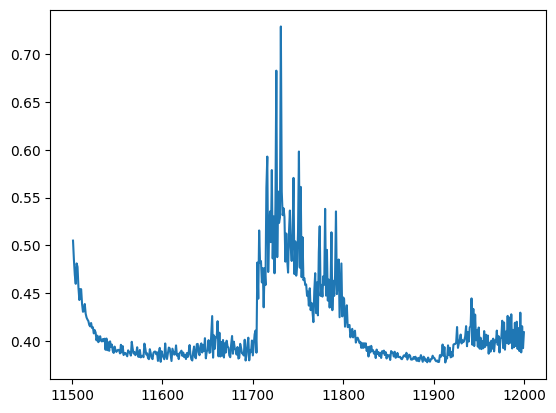

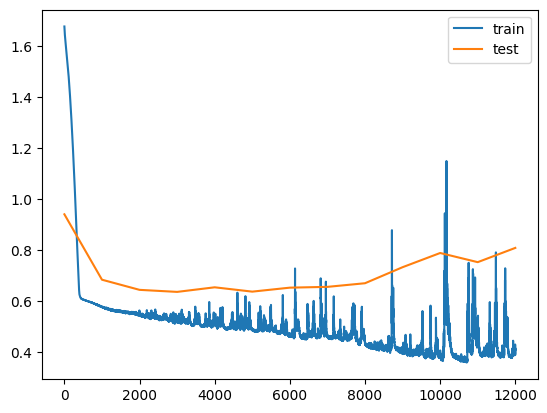

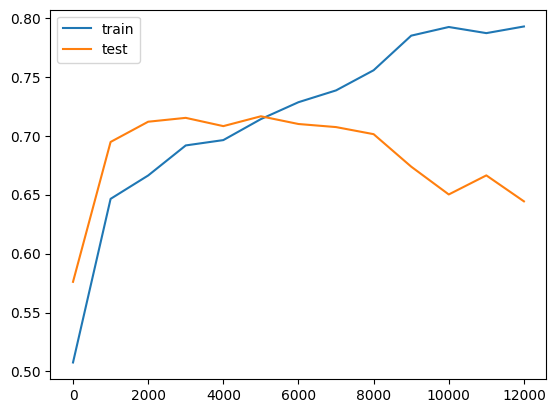

In [19]:
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.plot(txt[-500:], tlt[-500:], label="train")
plt.show()


plt.plot(txt, tlt, label="train")
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
plt.plot(tx, tl, label="test")
plt.legend()
plt.show()

tx = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
plt.plot(tx, tr, label="train")
te = [t[1] for t in results['test_r2s']]
plt.plot(tx, te, label="test")
plt.legend()
plt.show()

In [15]:
for i in results["test_r2s"]:
    print(i)
print(results["final_test_r2"])

(0, 0.6210749745368958)
(1000, 0.6777030229568481)
(2000, 0.6963992118835449)
(3000, 0.7051916122436523)
(4000, 0.7082806825637817)
(5000, 0.70531165599823)
(6000, 0.7068082690238953)
(7000, 0.7091169953346252)
(8000, 0.7049115896224976)
(9000, 0.702190637588501)
0.7002480626106262


tensor([-1.0189, -1.0655, -1.0695, -1.1094, -1.1051, -1.1490, -1.1726, -1.1626,
        -1.1985, -1.1764], device='cuda:0')
------
------
tensor([-3.8041, -2.4834, -3.2382, -3.5433,  3.4215, -3.3524, -2.1650, -2.5533,
         3.6936, -2.0375], device='cuda:0') tensor([ 7.5120,  2.1674,  5.3895,  3.6212, -7.5555,  4.8001,  4.7984,  3.9264,
        -7.9690,  4.5162], device='cuda:0')
tensor([-1.0244, -1.0506, -1.0744, -1.0982, -1.0960, -1.1352, -1.1756, -1.1365,
        -1.2124, -1.1860], device='cuda:0')


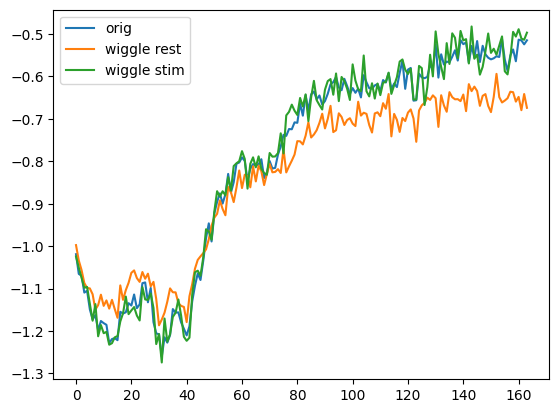

In [20]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -1.5
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(embeddings_stim, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

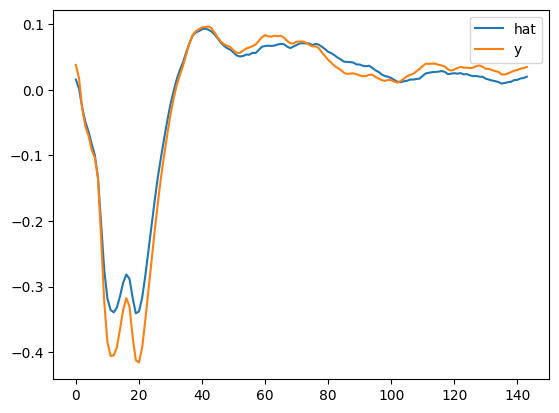

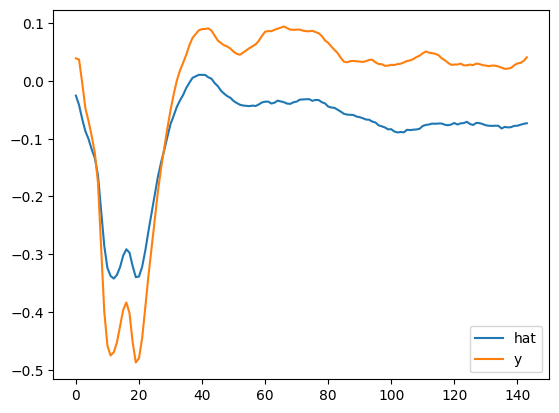

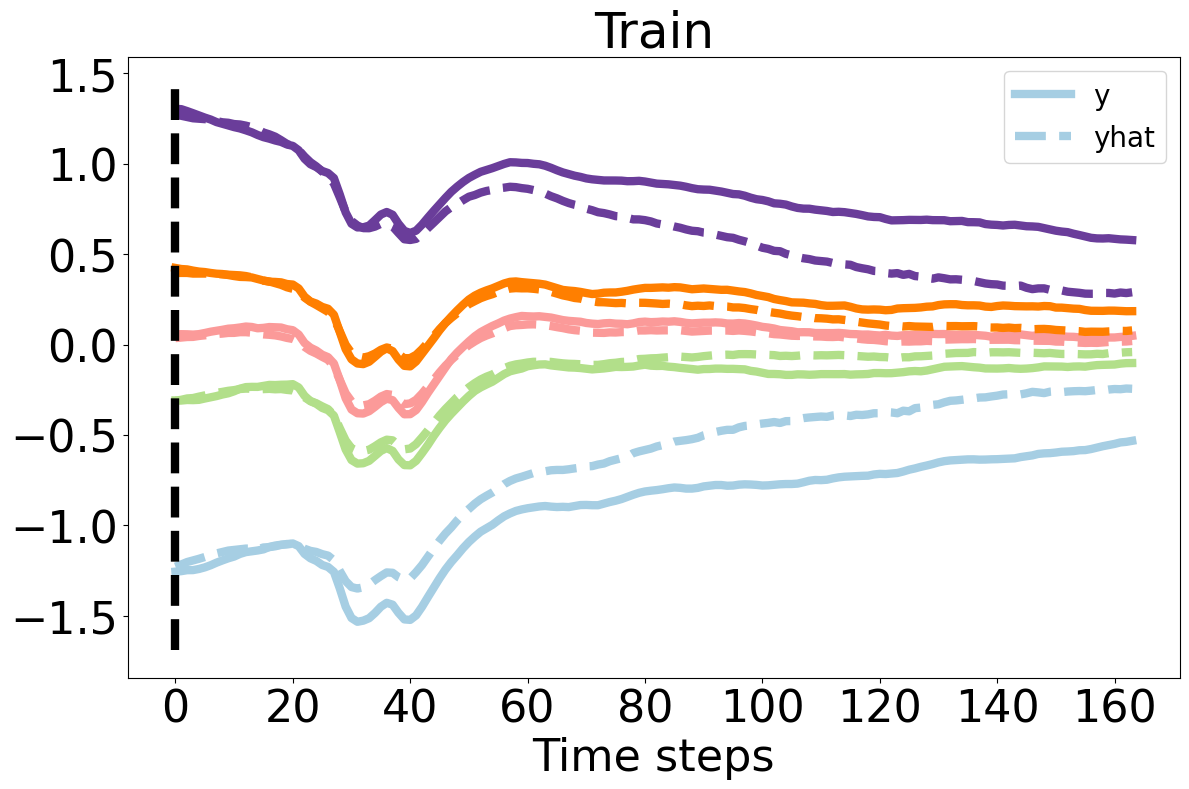

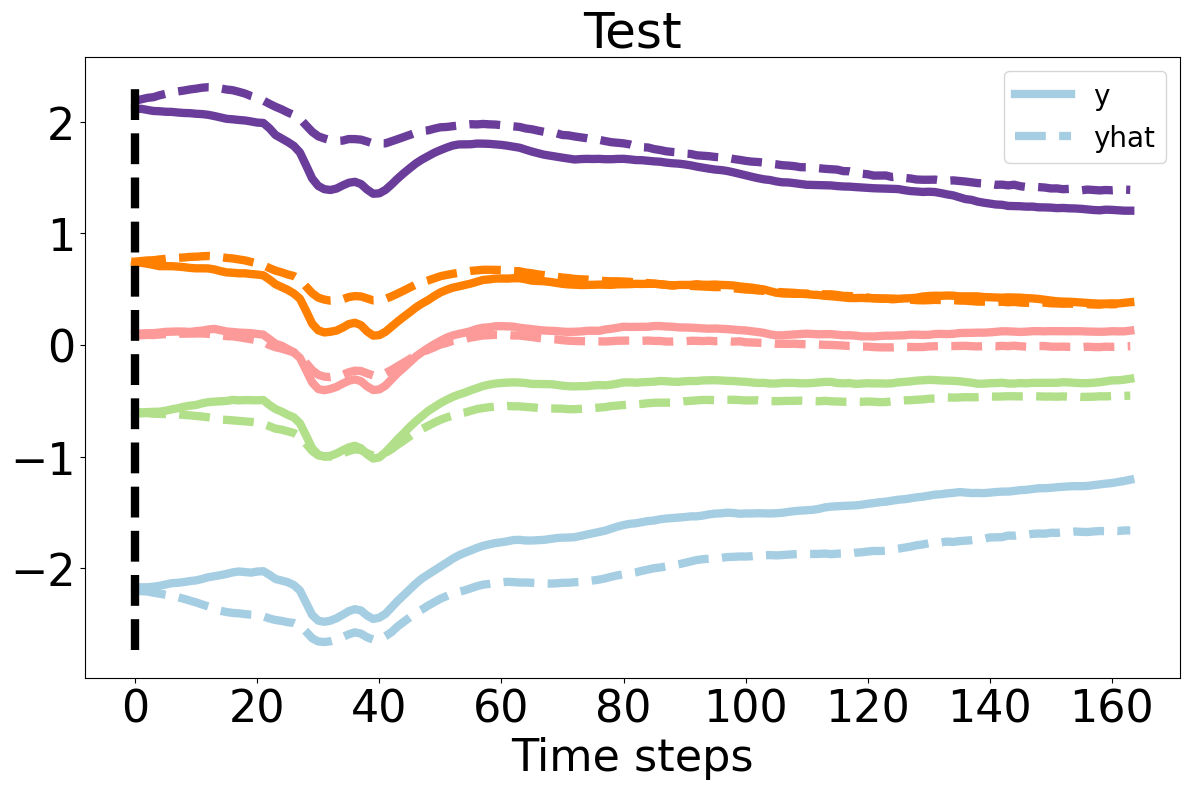

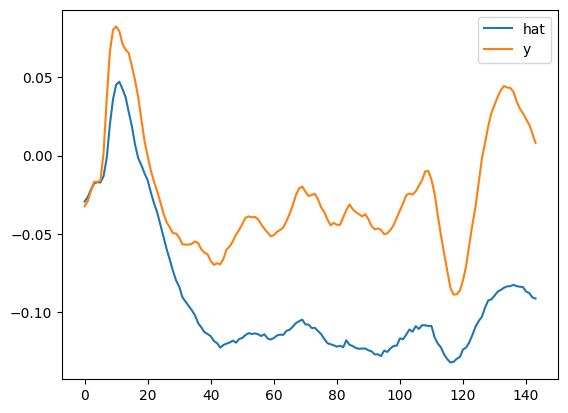

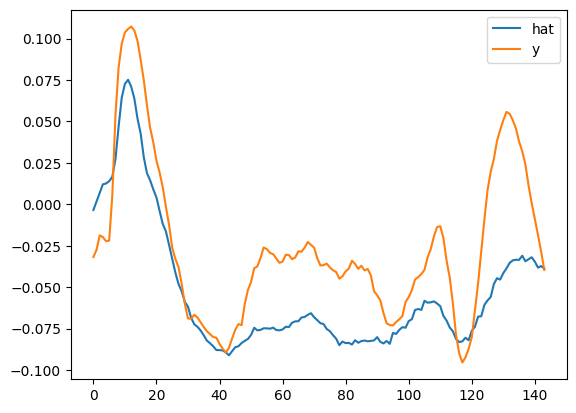

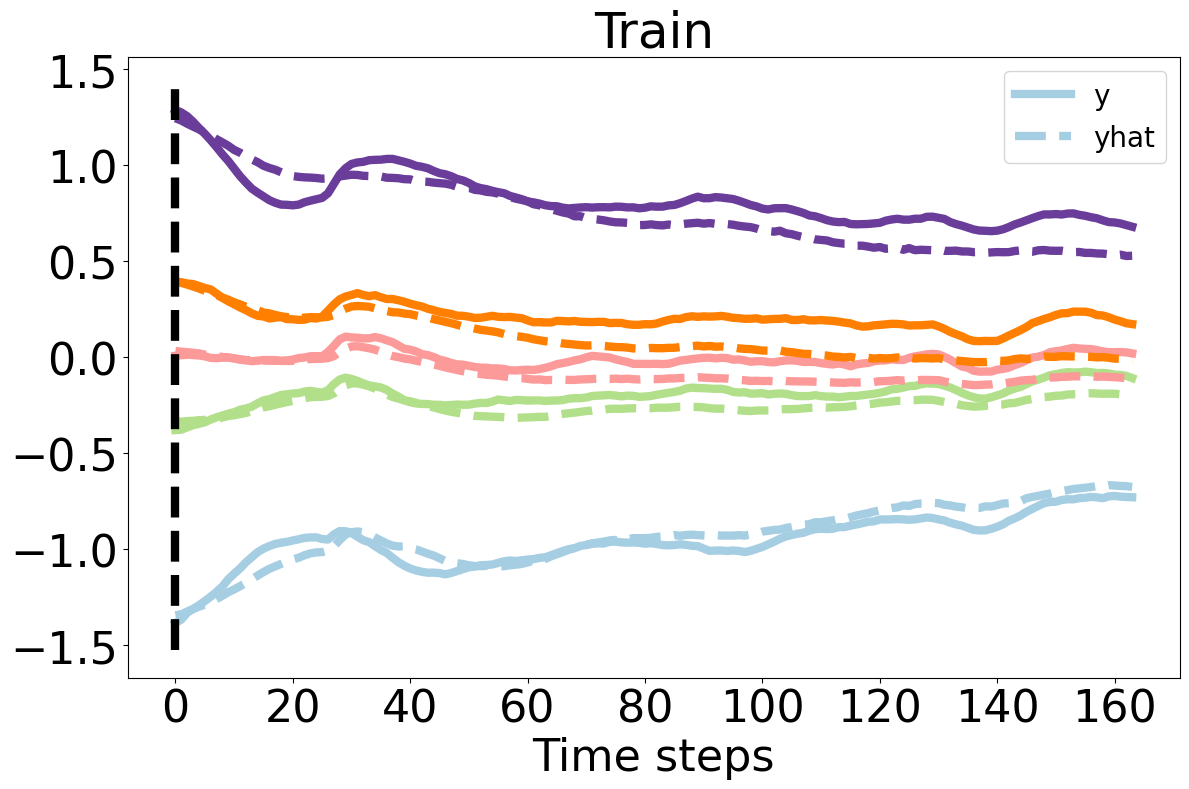

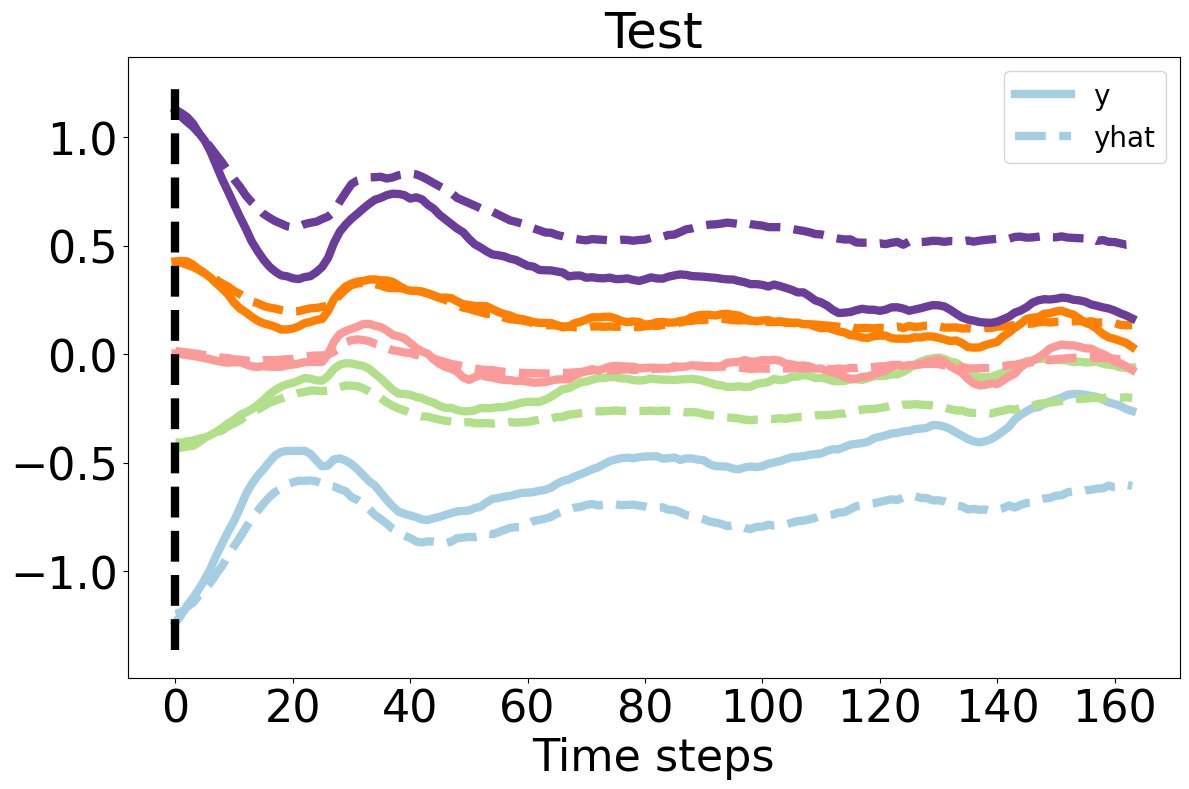

In [22]:
def graph_for_sid(sid, results, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()
    
    y_hat_mean = torch.mean(y_hats, dim=0)
    y_hat_test_mean = torch.mean(y_hats_test, dim=0)
    y_mean = torch.mean(y, dim=0)
    y_test_mean = torch.mean(y_test, dim=0)
    
    plt.plot(y_hat_mean[20:, cidx], label="hat")
    plt.plot(y_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()

    plt.plot(y_hat_test_mean[20:, cidx], label="hat")
    plt.plot(y_test_mean[20:, cidx], label="y")
    plt.legend()
    plt.show()
    
    test.graph_state_dependency(y, y_hats, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, title="Test", runway_length=0, ch=cidx)
    plt.show()
    
graph_for_sid('MonkeyG_20150925_Session2_S1', results, cidx=30)
graph_for_sid('MonkeyG_20150918_Session1_M1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)

In [ ]:
# Try:
# cfg.training.grad_clip = 2.0, 7.0
# cfg.tbfm.training.lambda_ortho = 0.01, 0.05, 0.1
# cfg.tbfm.module.num_bases = 15, 20, 25

for grad_clip in (2.0,):
    for num_bases in (15, 20, 25):
        for lambda_ortho in (0.01, 0.05, 0.1):
            print("---------------", grad_clip, num_bases, lambda_ortho)

            # cfg.tbfm.training.lambda_fro = regweight
            cfg.tbfm.module.num_bases = num_bases
            cfg.training.grad_clip = grad_clip
            # cfg.latent_dim = latent_dim
            # cfg.tbfm.training.optim.lr_head = lr_head
            cfg.tbfm.training.lambda_ortho = lambda_ortho
            cfg.tbfm.module.use_film_bases = True
            # cfg.ae.training.coadapt = True
            cfg.training.epochs = 20001

            ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
            model_optims = multisession.get_optims(cfg, ms)
            
            embeddings_stim, results = multisession.train_from_cfg(
                cfg,
                ms,
                data_train,
                model_optims,
                embeddings_rest,
                data_test=data_test,
                test_interval=5000,
                epochs=20001,
                )
            torch.save(results, f"res_{grad_clip}_{num_bases}_{lambda_ortho}.torch")

            del model_optims, ms

--------------- 2.0 15 0.01
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
---- 0 1.1330499649047852 0.9247554540634155 0.03832010179758072 0.061805590987205505
basis_weighting.weight         grad_norm=2.0000e+00, weight_norm=2.1510e+00, ratio=9.2982e-01
basis_weighting.bias           grad_norm=6.7800e-02, weight_norm=3.8891e+00, ratio=1.7433e-02
bases.in_layer.weight          grad_norm=4.7441e-03, weight_norm=3.3024e+00, ratio=1.4365e-03
bases.in_layer.bias            grad_norm=1.5774e-03, weight_norm=1.0543e+00, ratio=1.4962e-03
bases.hiddens.0.weight         grad_norm=1.9571e-03, weight_norm=3.9004e+00, ratio=5.0177e-04
bases.hiddens.0.bias           grad_norm=8.5569e-04, weight_norm=7.5115e-01, ratio=1.1392e-03
bases.hiddens.1.weight         grad_norm=1.9006e-03, weight_norm=3.8063e+00, ratio=4.9934e-04
bases.hiddens.1.bias           grad_norm=6.2266e-04, weight_norm=7.2910e-01, ratio=8.5402e-04
bases.out_layer.weight         

In [10]:
d = "."
f = [os.path.join(d, _f) for _f in os.listdir(d) if _f.startswith("res_") and _f.endswith(".torch")]
res = []
for _f in f:
    r = torch.load(_f)
    res.append((r["final_test_r2"], _f))
res.sort()

for rr in res[-10:]:
    print(rr)

# (0.4557589888572693, './res_0.07_17_70_10.0.torch')
# (0.4561246633529663, './res_0.05_12_50_10.0.torch')
# (0.45635348558425903, './res_0.01_17_70_10.0.torch')
# (0.4564235210418701, './res_0.07_17_70_1000.torch')
# (0.4569217562675476, './res_0.05_17_50_10.0.torch')
# (0.45701655745506287, './res_0.05_17_50_1000.torch')
# (0.4574051797389984, './res_0.05_20_70_1000.torch')
# (0.4576779007911682, './res_0.05_15_50_1000.torch')
# (0.45774632692337036, './res_0.05_15_70_1000.torch')
# (0.4579020142555237, './res_0.05_17_70_10.0.torch')

# Fro 0.05
# num_bases 17
# latent dim 70
# clip_grad None

(0.35666774378882515, './res_0.05_50_0.0003_0.2.torch')
(0.35697651902834576, './res_0.01_70_0.0003_0.3.torch')
(0.3569850954744551, './res_0.01_70_0.0001_0.1.torch')
(0.35736728376812404, './res_0.01_70_0.0001_0.3.torch')
(0.357471548848682, './res_0.01_50_0.0003_0.1.torch')
(0.35761067602369523, './res_0.01_70_0.0002_0.2.torch')
(0.35779477490319145, './res_0.01_70_0.0003_0.2.torch')
(0.3578372299671173, './res_0.01_70_0.0003_0.1.torch')
(0.35784753163655597, './res_0.01_50_0.0003_0.2.torch')
(0.357981413602829, './res_0.01_70_0.0002_0.1.torch')


In [10]:
# Let's try TTA
new_stim_embeddings, results_tta = multisession.test_time_adaptation(cfg, ms, embeddings_rest, data_train, epochs=2000, data_test=data_test)
print(results["final_test_r2s"])

0 0.49247241020202637
100 0.46171706914901733
200 0.46164658665657043
300 0.4613754153251648
400 0.4632904529571533
500 0.4616580605506897
600 0.4613192677497864
700 0.4614813029766083
800 0.46113014221191406
900 0.4618266820907593
1000 0.4632616341114044
1100 0.46187305450439453
1200 0.46091848611831665
1300 0.4628392457962036
1400 0.46345943212509155
1500 0.461905300617218
1600 0.4627213776111603
1700 0.46067100763320923
1800 0.4617919623851776
1900 0.46190696954727173
{'MonkeyG_20150918_Session1_M1': 0.7359708547592163, 'MonkeyG_20150925_Session2_S1': 0.6784844398498535}


tensor([-0.8678, -0.8862, -0.8865, -0.9223, -0.9255, -0.9209, -0.9342, -0.9447,
        -0.9387, -0.9444], device='cuda:0')
------
tensor([-0.7341, -0.3132, -0.8457, -0.2566, -0.6028,  0.5226, -0.5716,  0.8597,
        -0.7821, -0.2854], device='cuda:0') tensor([ 1.8088,  0.5398,  2.5179,  0.3788,  1.0801, -1.5133,  0.7048, -1.6741,
         1.4876,  0.3232], device='cuda:0')
tensor([-0.9907, -1.0247, -1.0651, -1.0977, -1.1122, -1.1457, -1.1533, -1.1576,
        -1.1603, -1.1456], device='cuda:0')


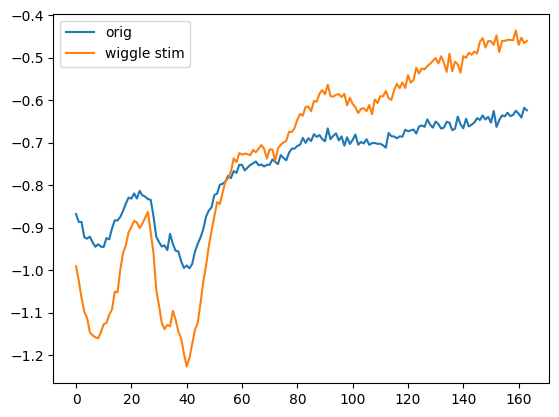

In [10]:
# see how much predictions change as I tweak embeddings
sid = "MonkeyG_20150925_Session2_S1"

def wiggle(stuff, quiet=True):
    out = {}
    for sid, thing in stuff.items():
        out[sid] = thing * (torch.rand(thing.shape).to(thing.device) + 0.5) * -2
    if not quiet:
        print(thing[:10], out[sid][:10])

    return out

ch = 30
    
with torch.no_grad():
    ms.eval()
    dt = next(iter(data_test))
    dt = utils.move_batch(dt, device=DEVICE)
    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="orig")
    print(preds[sid][0][:, ch][:10])
    print("------")
    
    # preds = ms(dt, embeddings_rest=wiggle(embeddings_rest), embeddings_stim=embeddings_stim)
    # plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle rest")
    # print("------")

    preds = ms(dt, embeddings_rest=embeddings_rest, embeddings_stim=wiggle(new_stim_embeddings, quiet=False))
    plt.plot(preds[sid][0][:, ch].detach().cpu(), label="wiggle stim")
    print(preds[sid][0][:, ch][:10])
plt.legend()
plt.show()

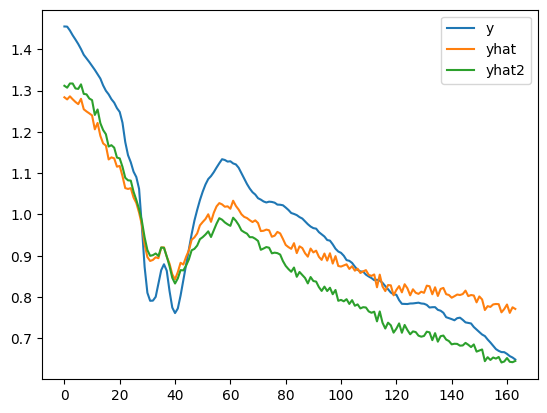

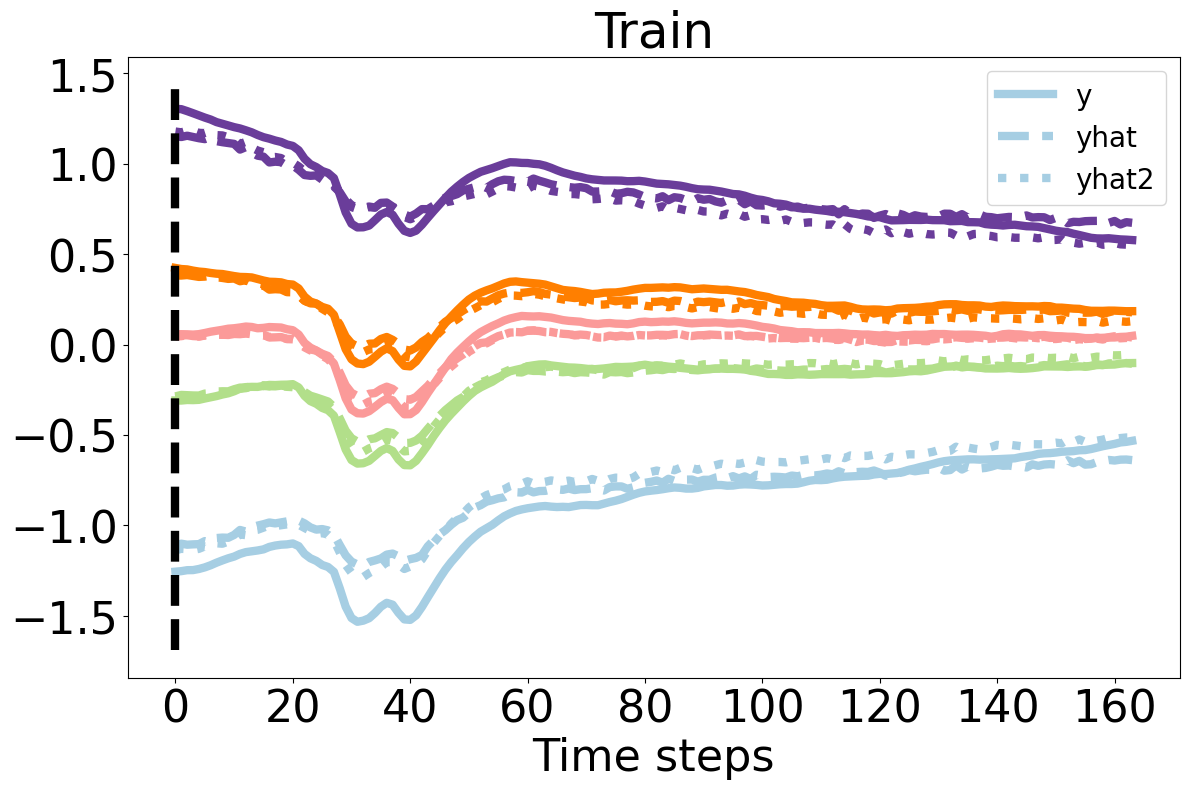

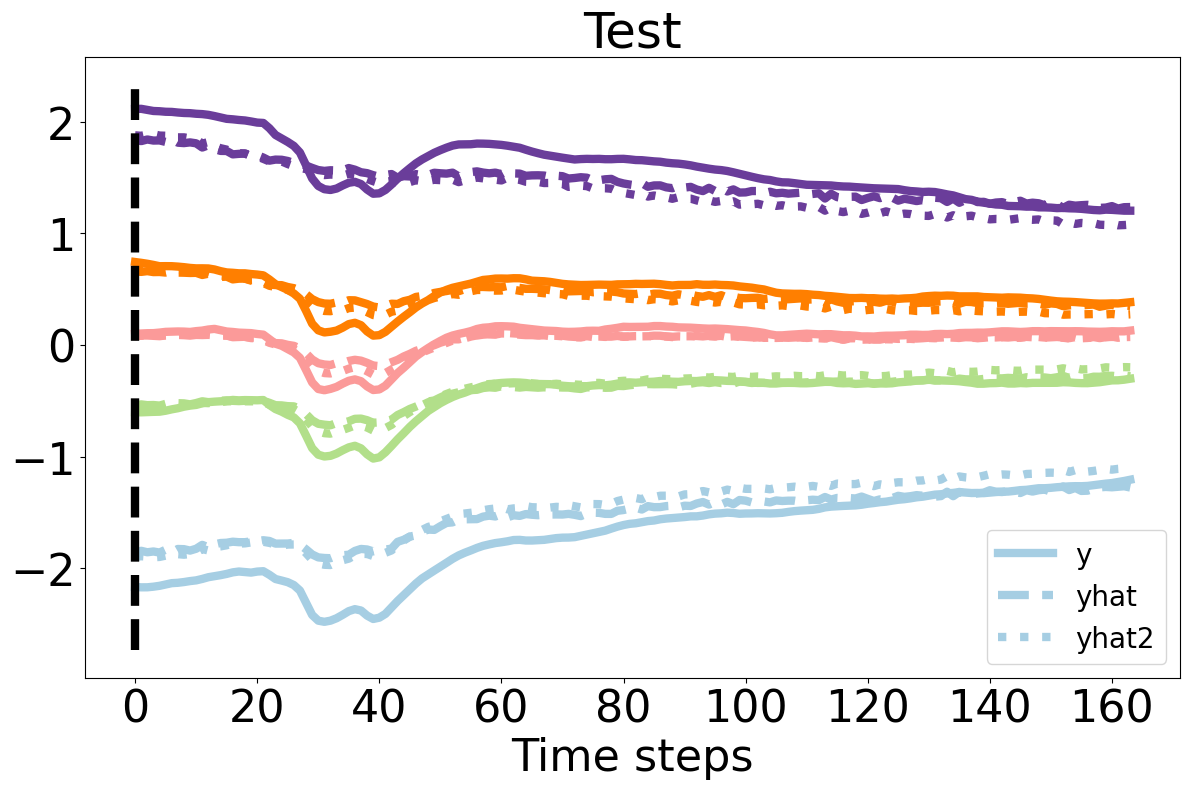

In [11]:
def graph_for_sid_tta(sid, results, results_tta, data_train, model, new_stim_embeddings, support_size=300, cidx=32):
    from tbfm import test
    
    y_hats = results['y_hat'][sid].detach().cpu()
    y_hats_test = results['y_hat_test'][sid].detach().cpu()
    
    y = results['y'][sid].detach().cpu()
    y_test = results['y_test'][sid][2].detach().cpu()

    y_hats_test2 = results_tta['y_hat_test'][sid].detach().cpu()

    model.eval()
    with torch.no_grad():
        dt = {sid: next(iter(data_train))[sid]}
        dt = utils.move_batch(dt, device=DEVICE)
        d = dt[sid]
        y_norm = model.norms.instances[sid](d[2])             
        new_d = (d[0][support_size:], d[1][support_size:], y_norm[support_size:])                    
        dt = {sid: new_d}
        y_hats2 = model(dt, embeddings_rest=embeddings_rest, embeddings_stim=new_stim_embeddings)[sid]

    _y = []
    _yhat = []
    _yhat2 = []
    for bidx in range(y_hats2.shape[0]):
        __y = dt[sid][2][bidx, :, cidx]
        if __y[0] > 0.8:
            _y.append(__y.unsqueeze(0))
            _yhat.append(y_hats[bidx, :, cidx].unsqueeze(0))
            _yhat2.append(y_hats2[bidx, :, cidx].unsqueeze(0))
    _y = torch.mean(torch.cat(_y, dim=0), dim=0).detach().cpu()
    _yhat = torch.mean(torch.cat(_yhat, dim=0), dim=0).detach().cpu()
    _yhat2 = torch.mean(torch.cat(_yhat2, dim=0), dim=0).detach().cpu()
    plt.plot(_y, label="y")
    plt.plot(_yhat, label="yhat")
    plt.plot(_yhat2, label="yhat2")
    plt.legend()
    plt.show()

    test.graph_state_dependency(y, y_hats, yhat2=y_hats2, title="Train", runway_length=0, ch=cidx)
    test.graph_state_dependency(y_test, y_hats_test, yhat2=y_hats_test2, title="Test", runway_length=0, ch=cidx)

graph_for_sid_tta('MonkeyG_20150925_Session2_S1', results, results_tta, data_train, ms, new_stim_embeddings, cidx=30)
# graph_for_sid('MonkeyJ_20160630_Session3_S1', results)
# graph_for_sid('MonkeyG_20150917_Session3_S1', results)



In [21]:
print(results.keys())

dict_keys(['final_test_r2', 'final_test_r2s', 'final_test_loss', 'y_hat_test', 'y_test'])
